<a href="https://colab.research.google.com/github/Procatv/Grover/blob/main/QXQ_EQCI_Lab_6_%5BSOLUTIONS%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Lab 6: Grover's Search**
---

### **Description**
In today's lab, we will implement Grover's Algorithm using Qiskit's `Grover` function. Here, instead of creating the circuit gate-by-gate, we are going to use a built-in function to make the circuit for us. This approach will allow us to focus on Grover's search at a high-level.

<br>

### **Lab Structure**
**Part 1**: [Defining the size of the problem](#p1)

**Part 2**: [Setting up the Grover problem](#p2)

**Part 3**: [Visualizing the results of Grover's algorithm](#p3)

<br>

### **Goals** 
By the end of this lab, you will:
* Understand the Grover's search algorithm.
* Implement Grover's search with the built-in Qiskit library. 
* Implement Grover's search from scratch for two qubits.


<br>

**Before starting, run the code below to import all necessary functions and libraries.**
You will notice some new libraries here - `AmplificationProblem`, `Grover`, and `Statevector`. These will all be used to implement Grover's Algorithm. We will describe what each library is used for when we use them.

In [ ]:
!pip install qiskit

import numpy as np
import math
import scipy

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ
from qiskit.tools.jupyter import *
from qiskit.visualization import *

# from ibm_quantum_widgets import *
from qiskit.providers.aer import QasmSimulator
from qiskit.algorithms import AmplificationProblem
from qiskit.algorithms import Grover
import math
from qiskit.quantum_info import Statevector
import matplotlib.pyplot as plt

# Loading your IBM Quantum account(s)
# provider = IBMQ.load_account()

import warnings
warnings.filterwarnings("ignore")

print("Libraries Imported Successfully!")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 46.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 78.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.5/241.5 kB 23.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 68.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.5/37.5 MB 12.1 MB/s eta 0:00:00


<a name="p1"></a>

---
## **Part 1: Defining the size of the problem**
---

In this part, we will set up the search problem by specifying the number of choices we are searching through, and the choice we are searching for. Remember that in a search problem, we know what we are looking for - we just don't know where it is located.

#### **Problem #1.1**
**Together,** let's create a variable named `number_choices` to store the total number of choices you want to search through. Make sure that the number of choices you use is a power of 2, otherwise later code will produce errors. We recommend starting with 8 choices.

Create a second variable named `correct_choice`, and give it the number of the choice you are searching for.

###### **Solution**


In [ ]:
number_choices= 8 # Total number of choices - please ensure that this number is a power of 2.
correct_choice = 3 # Choice number you are searching for

#### **Problem #1.2**
**Together**, let's determine how many qubits would be needed in Grover's algorithm for the number of choices you entered?

In [ ]:
# ENTER THE NUMBER HERE

###### **Solution**
3

#### **Run the code below to create a binary representation of each of the `number_choices` that you entered.**

**This is important** because these binary representations will then get encoded into the corresponding quantum state. 

For example, suppose you entered `number_choices = 8`. Choice number 0 will be converted to $000$, and encoded in the quantum state $|000\rangle$. Choice 5 will be converted to $101$, and be encoded in the quantum state $|101\rangle$.

In [ ]:
def generate_binary_strings(number_choices):
    n = int(math.log(number_choices,2)) 
    binary_strings = []
    for i in range(2**n):
        binary_string = bin(i)[2:].zfill(n)
        binary_strings.append(binary_string)
    return binary_strings

#### **Problem #1.3**
**Independently,** utilizing the provided function, generate a list named `ls`, that contains the binary representation of each of the`number_choices`.

In [ ]:
# COMPLETE THIS CODE

###### **Solution**

In [ ]:
ls = generate_binary_strings(number_choices)
ls

['000', '001', '010', '011', '100', '101', '110', '111']

<a name="p2"></a>

---
## **Part 2: Setting up the Grover problem**
---

In this part, we will use Qiskit's `AmplificationProblem` and `Grover` functions to set up Grover's search. `AmplificationProblem` sets up the oracle and defines the search problem. `Grover` solves the search problem by applying Grover's algorithm to it.

First, we will define the search problem using `AmplificationProblem`. To do this, we have to create the Oracle. Remember from lecture that the Oracle flips the sign of the correct state. So, to create the oracle, we need to specify the correct state. After we have created the oracle, we use it as a paramter in the `AmplificationProblem` function to create the search problem.


#### **Problem #2.1**

**Together**, let's create the oracle, and then use it to create the search problem.

In [ ]:
oracle = Statevector.from_label(ls[# COMPLETE THIS LINE
problem = AmplificationProblem(oracle, is_good_state=[# COMPLETE THIS LINE

###### **Solution**


In [ ]:
# Defining the grover problem using the AmplificationProblem function
# In this step we take the binary representations we created in the last step and define the problem we want to solve.
# We use the correct choice to create the oracle matrix
# The AmplificationProblem function defines the grover problem

oracle = Statevector.from_label(ls[correct_choice])
problem = AmplificationProblem(oracle, is_good_state=[ls[correct_choice]])

#### **Problem #2.2**

**Together**, we will solve the search problem using Qiskit's `Grover` function. `Grover` needs two inputs - the number of iterations of the algorithm that you want to apply, and the backend you want to use.

**Run the cell below as is and then rerun the cell after changing the number of iterations to 2.**

In [ ]:
backend = Aer.get_backend('qasm_simulator')# Enter the QASM simulator here
grover = Grover(iterations=0, quantum_instance=backend) # Enter the number of iterations here
result = grover.amplify(problem) # This line of code applies Grover's algorithm to the problem and gets the result

###### **Solution**


In [ ]:
backend = Aer.get_backend('qasm_simulator')# Enter the QASM simulator here
grover = Grover(iterations=2, quantum_instance=backend) # Enter the number of iterations here
result = grover.amplify(problem) # This line of code applies Grover's algorithm to the problem and gets the result

#### **Problem #2.3**

**Together, let's run the code below to look at the state preparation part of the circuit.**

In [ ]:
problem.grover_operator.state_preparation.draw()

┌───┐
q_0: ┤ H ├
     ├───┤
q_1: ┤ H ├
     ├───┤
q_2: ┤ H ├
     └───┘

#### **Problem #2.4**

**Together, let's run the two cells below to look at the oracle and its decomposition.**

In [ ]:
problem.grover_operator.oracle.draw()

┌───────────┐
q_0: ┤0          ├
     │           │
q_1: ┤1 Diagonal ├
     │           │
q_2: ┤2          ├
     └───────────┘

In [ ]:
problem.grover_operator.oracle.decompose().draw()

global phase: π/8
     ┌────────────────┐                              
q_0: ┤0               ├──────────────────────────────
     │                │┌──────────────┐              
q_1: ┤1 Ucrz(0,π,0,0) ├┤0             ├──────────────
     │                ││  Ucrz(π/2,0) │┌────────────┐
q_2: ┤2               ├┤1             ├┤ Ucrz(-π/4) ├
     └────────────────┘└──────────────┘└────────────┘

#### **Problem #2.5**

**Together, let's run the two cells below to look at the grover operator and the decomposed circuit.**

In [ ]:
problem.grover_operator.draw()

┌────┐
state_0: ┤0   ├
         │    │
state_1: ┤1 Q ├
         │    │
state_2: ┤2   ├
         └────┘

In [ ]:
problem.grover_operator.decompose().draw()

global phase: π
         ┌───────────┐┌───┐┌───┐          ┌───┐┌───┐     
state_0: ┤0          ├┤ H ├┤ X ├───────■──┤ X ├┤ H ├─────
         │           │├───┤├───┤       │  ├───┤├───┤     
state_1: ┤1 Diagonal ├┤ H ├┤ X ├───────■──┤ X ├┤ H ├─────
         │           │├───┤├───┤┌───┐┌─┴─┐├───┤├───┤┌───┐
state_2: ┤2          ├┤ H ├┤ X ├┤ H ├┤ X ├┤ H ├┤ X ├┤ H ├
         └───────────┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘

<a name="p3"></a>

---
## **Part 3: Visualizing the results of Grover's algorithm**
---
In the final part of implementing Grover's, we will extract the results from running the algorithm and plot the results. The results will be shown in the form of the measurement probabilities of all the different choices. 

**Run the cell below to see the first measurement results.**

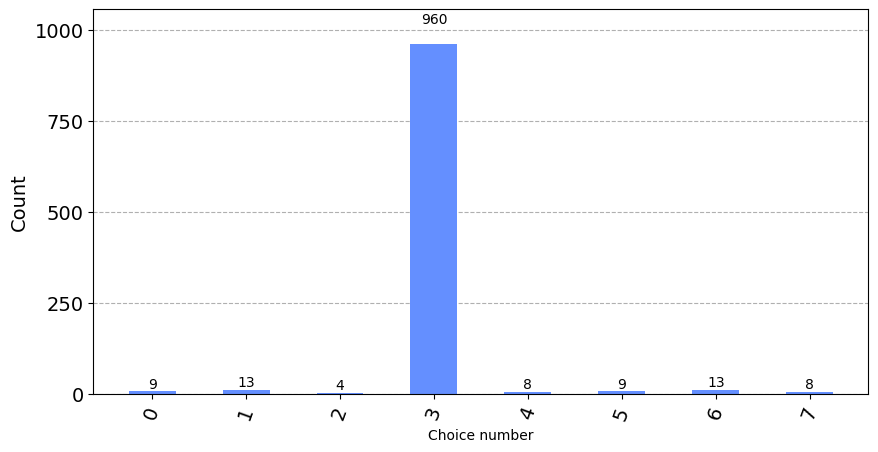

In [ ]:
# Extracting probabilities from the result of solving Grover
counts = result.circuit_results[0]
counts = counts.int_outcomes()

# Plotting probabilities 
# Don't worry about all the details of how the plot is made
# All the code after the first line just makes the plot look nice
plot = plot_histogram(counts,figsize=(10, 5))
ax = plot.gca()
xticks = []
ax.set_xlabel("Choice number")
display(plot)

#### **Problem #3.1**
**Independently**, visualize the measurement outcomes you get with zero grover iterations. Do the results make sense?

In [ ]:
# COMPLETE THIS CODE

##### **Solution**

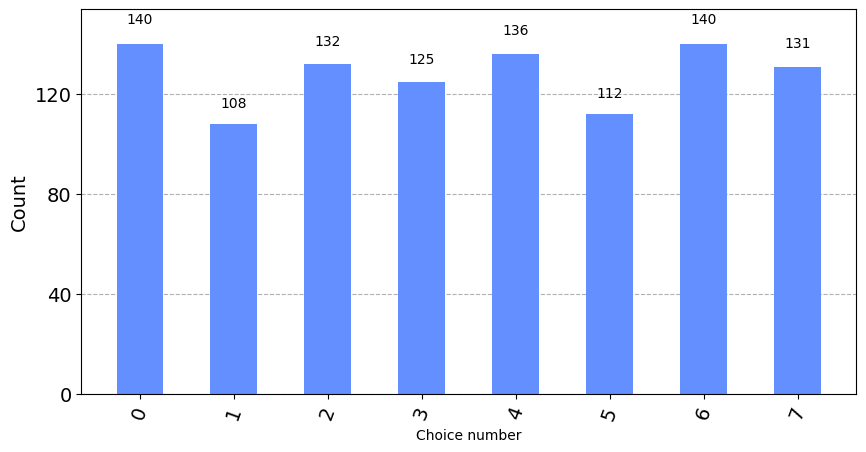

In [ ]:
backend = Aer.get_backend('qasm_simulator')
grover = Grover(iterations=0, quantum_instance=backend)
result = grover.amplify(problem)

# Extracting probabilities from the result of solving Grover
counts = result.circuit_results[0]
counts = counts.int_outcomes()

# Plotting probabilities 
# Don't worry about all the details of how the plot is made
# All the code after the first line just makes the plot look nice
plot = plot_histogram(counts,figsize=(10, 5))
ax = plot.gca()
xticks = []
ax.set_xlabel("Choice number")
display(plot)

With zero iterations it is not clear which is the correct item - Grover's search has not been done for an optimal number of iterations.

#### **Problem #3.2**

**Independently**, visualize the results for Grover's algorithm on this problem for 0 to 10 iterations. For each number of iterations, notice the histogram. What changes do you observe? Do you see amplitude amplification? Does the right choice's amplitude get amplified?

**Using these results, answer what is the optimal number of iterations that maximizes the amplification of the right choice's amplitude?**

In [ ]:
# COMPLETE THIS CODE FOR 0 ITERATIONS

In [ ]:
# COMPLETE THIS CODE FOR 1 ITERATIONS

In [ ]:
# COMPLETE THIS CODE FOR 2 ITERATIONS

In [ ]:
# COMPLETE THIS CODE FOR 3 ITERATIONS

In [ ]:
# COMPLETE THIS CODE FOR 4 ITERATIONS

In [ ]:
# COMPLETE THIS CODE FOR 5 ITERATIONS

In [ ]:
# COMPLETE THIS CODE FOR 6 ITERATIONS

In [ ]:
# COMPLETE THIS CODE FOR 7 ITERATIONS

In [ ]:
# COMPLETE THIS CODE FOR 8 ITERATIONS

In [ ]:
# COMPLETE THIS CODE FOR 9 ITERATIONS

In [ ]:
# COMPLETE THIS CODE FOR 10 ITERATIONS

##### **Solution**

2 is the optimal number. 


You will notice that the probability of the correct choice increases as you increase the number of iterations! This is amplitude amplification in action.


You will also notice that if you exceed the optimal number of iterations, the probability of measuring the correct choice goes down. There is an **optimal** number of iterations - at this number of iterations, the probability of successfully finding the right state is maximized.

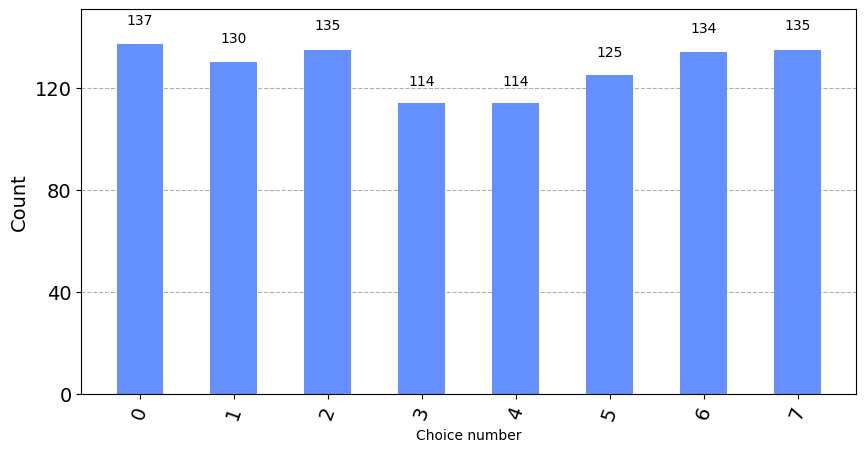

In [ ]:
backend = Aer.get_backend('qasm_simulator')
grover = Grover(iterations=0, quantum_instance=backend)
result = grover.amplify(problem)

# Extracting probabilities from the result of solving Grover
counts = result.circuit_results[0]
counts = counts.int_outcomes()

# Plotting probabilities 
# Don't worry about all the details of how the plot is made
# All the code after the first line just makes the plot look nice
plot = plot_histogram(counts,figsize=(10, 5))
ax = plot.gca()
xticks = []
ax.set_xlabel("Choice number")
display(plot)

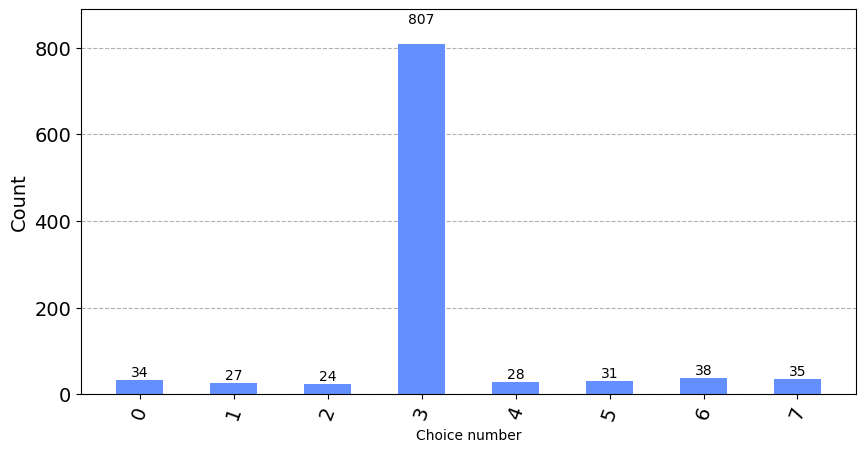

In [ ]:
backend = Aer.get_backend('qasm_simulator')
grover = Grover(iterations=1, quantum_instance=backend)
result = grover.amplify(problem)

# Extracting probabilities from the result of solving Grover
counts = result.circuit_results[0]
counts = counts.int_outcomes()

# Plotting probabilities 
# Don't worry about all the details of how the plot is made
# All the code after the first line just makes the plot look nice
plot = plot_histogram(counts,figsize=(10, 5))
ax = plot.gca()
xticks = []
ax.set_xlabel("Choice number")
display(plot)

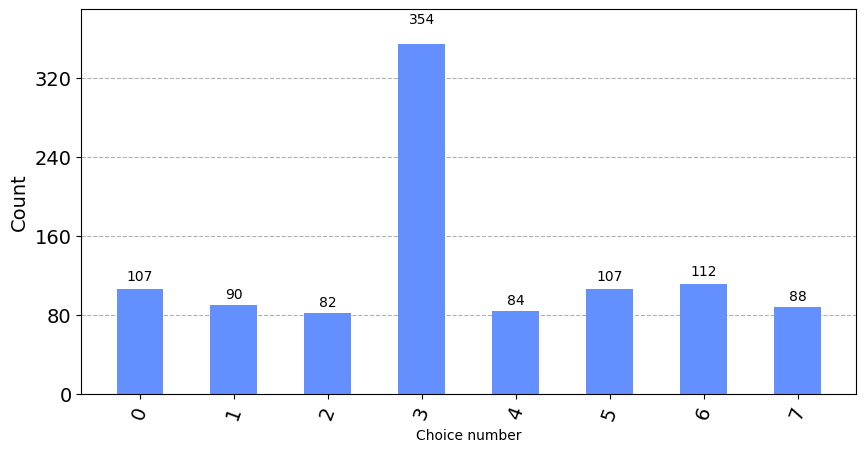

In [ ]:
backend = Aer.get_backend('qasm_simulator')
grover = Grover(iterations=3, quantum_instance=backend)
result = grover.amplify(problem)

# Extracting probabilities from the result of solving Grover
counts = result.circuit_results[0]
counts = counts.int_outcomes()

# Plotting probabilities 
# Don't worry about all the details of how the plot is made
# All the code after the first line just makes the plot look nice
plot = plot_histogram(counts,figsize=(10, 5))
ax = plot.gca()
xticks = []
ax.set_xlabel("Choice number")
display(plot)

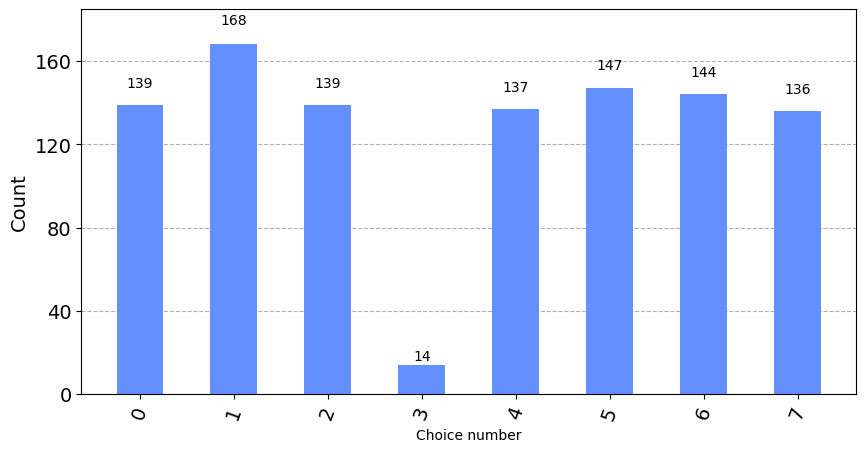

In [ ]:
backend = Aer.get_backend('qasm_simulator')
grover = Grover(iterations=4, quantum_instance=backend)
result = grover.amplify(problem)

# Extracting probabilities from the result of solving Grover
counts = result.circuit_results[0]
counts = counts.int_outcomes()

# Plotting probabilities 
# Don't worry about all the details of how the plot is made
# All the code after the first line just makes the plot look nice
plot = plot_histogram(counts,figsize=(10, 5))
ax = plot.gca()
xticks = []
ax.set_xlabel("Choice number")
display(plot)

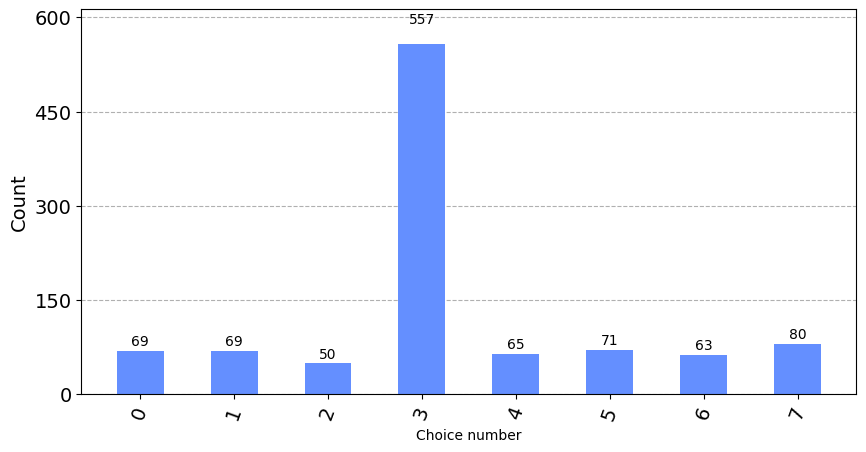

In [ ]:
backend = Aer.get_backend('qasm_simulator')
grover = Grover(iterations=5, quantum_instance=backend)
result = grover.amplify(problem)

# Extracting probabilities from the result of solving Grover
counts = result.circuit_results[0]
counts = counts.int_outcomes()

# Plotting probabilities 
# Don't worry about all the details of how the plot is made
# All the code after the first line just makes the plot look nice
plot = plot_histogram(counts,figsize=(10, 5))
ax = plot.gca()
xticks = []
ax.set_xlabel("Choice number")
display(plot)

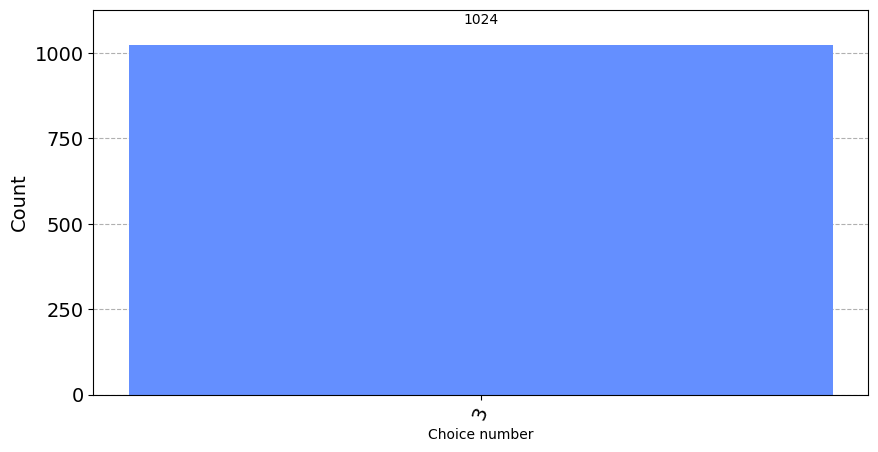

In [ ]:
backend = Aer.get_backend('qasm_simulator')
grover = Grover(iterations=6, quantum_instance=backend)
result = grover.amplify(problem)

# Extracting probabilities from the result of solving Grover
counts = result.circuit_results[0]
counts = counts.int_outcomes()

# Plotting probabilities 
# Don't worry about all the details of how the plot is made
# All the code after the first line just makes the plot look nice
plot = plot_histogram(counts,figsize=(10, 5))
ax = plot.gca()
xticks = []
ax.set_xlabel("Choice number")
display(plot)

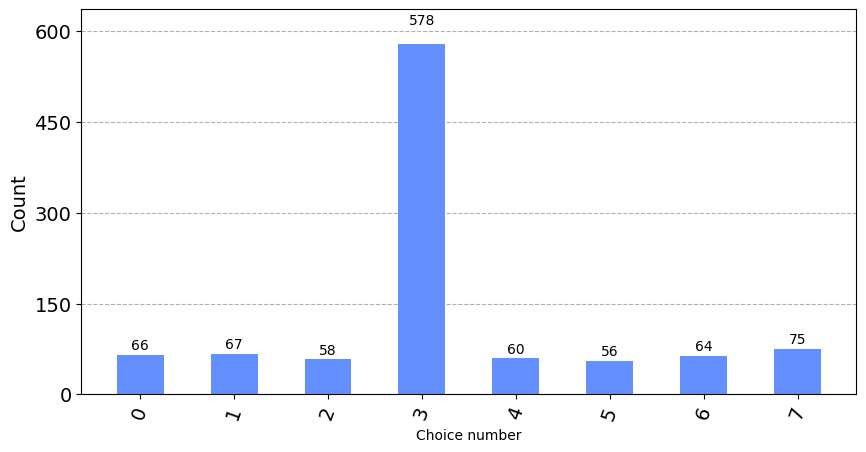

In [ ]:
backend = Aer.get_backend('qasm_simulator')
grover = Grover(iterations=7, quantum_instance=backend)
result = grover.amplify(problem)

# Extracting probabilities from the result of solving Grover
counts = result.circuit_results[0]
counts = counts.int_outcomes()

# Plotting probabilities 
# Don't worry about all the details of how the plot is made
# All the code after the first line just makes the plot look nice
plot = plot_histogram(counts,figsize=(10, 5))
ax = plot.gca()
xticks = []
ax.set_xlabel("Choice number")
display(plot)

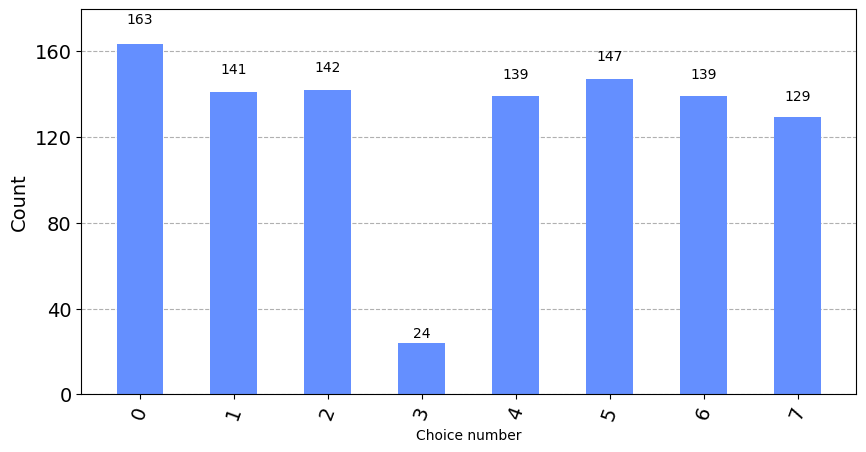

In [ ]:
backend = Aer.get_backend('qasm_simulator')
grover = Grover(iterations=8, quantum_instance=backend)
result = grover.amplify(problem)

# Extracting probabilities from the result of solving Grover
counts = result.circuit_results[0]
counts = counts.int_outcomes()

# Plotting probabilities 
# Don't worry about all the details of how the plot is made
# All the code after the first line just makes the plot look nice
plot = plot_histogram(counts,figsize=(10, 5))
ax = plot.gca()
xticks = []
ax.set_xlabel("Choice number")
display(plot)

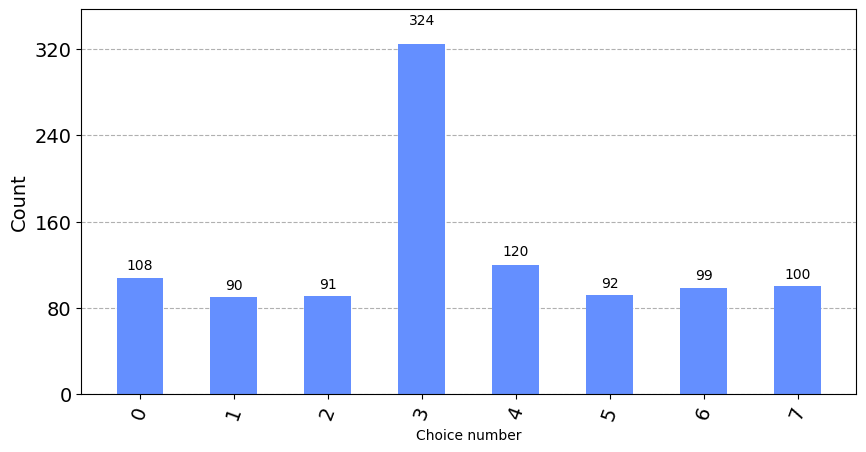

In [ ]:
backend = Aer.get_backend('qasm_simulator')
grover = Grover(iterations=9, quantum_instance=backend)
result = grover.amplify(problem)

# Extracting probabilities from the result of solving Grover
counts = result.circuit_results[0]
counts = counts.int_outcomes()

# Plotting probabilities 
# Don't worry about all the details of how the plot is made
# All the code after the first line just makes the plot look nice
plot = plot_histogram(counts,figsize=(10, 5))
ax = plot.gca()
xticks = []
ax.set_xlabel("Choice number")
display(plot)

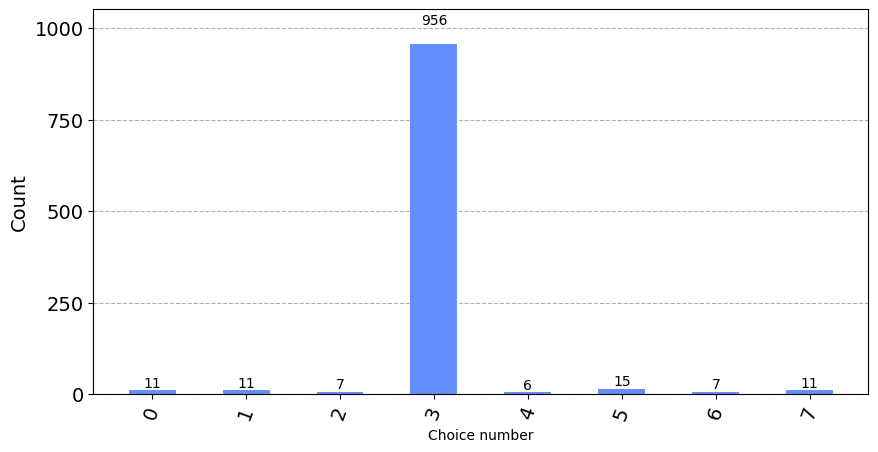

In [ ]:
backend = Aer.get_backend('qasm_simulator')
grover = Grover(iterations=10, quantum_instance=backend)
result = grover.amplify(problem)

# Extracting probabilities from the result of solving Grover
counts = result.circuit_results[0]
counts = counts.int_outcomes()

# Plotting probabilities 
# Don't worry about all the details of how the plot is made
# All the code after the first line just makes the plot look nice
plot = plot_histogram(counts,figsize=(10, 5))
ax = plot.gca()
xticks = []
ax.set_xlabel("Choice number")
display(plot)

#### **Problem #3.3**
Now, let's play around with the size of the problem by changing the list to contain 32 elements. Change the value of `number_choices`. **Keep in mind that this number has to be a power of 2, otherwise the code will produce an error.** 
 

**Independently**, find the element 28, in a list of 32 elements using the code given above. Answer the following:
1. How many qubits are required?
2. How many Grover iterations did you need? 

##### **Solution**

In [ ]:
number_choices= 32
correct_choice = 28
ls = generate_binary_strings(number_choices)

oracle = Statevector.from_label(ls[correct_choice])
problem = AmplificationProblem(oracle, is_good_state=[ls[correct_choice]])

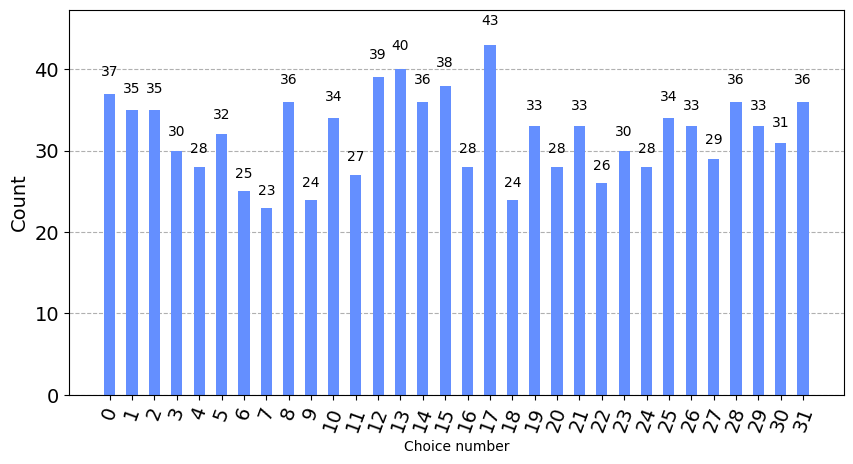

In [ ]:
backend = Aer.get_backend('qasm_simulator')
grover = Grover(iterations=0, quantum_instance=backend)
result = grover.amplify(problem)

# Extracting probabilities from the result of solving Grover
counts = result.circuit_results[0]
counts = counts.int_outcomes()

# Plotting probabilities 
# Don't worry about all the details of how the plot is made
# All the code after the first line just makes the plot look nice
plot = plot_histogram(counts,figsize=(10, 5))
ax = plot.gca()
xticks = []
ax.set_xlabel("Choice number")
display(plot)

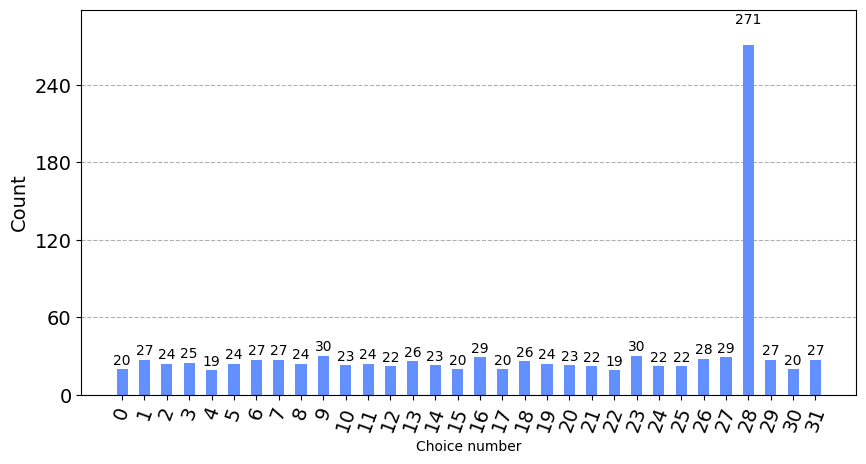

In [ ]:
backend = Aer.get_backend('qasm_simulator')
grover = Grover(iterations=1, quantum_instance=backend)
result = grover.amplify(problem)

# Extracting probabilities from the result of solving Grover
counts = result.circuit_results[0]
counts = counts.int_outcomes()

# Plotting probabilities 
# Don't worry about all the details of how the plot is made
# All the code after the first line just makes the plot look nice
plot = plot_histogram(counts,figsize=(10, 5))
ax = plot.gca()
xticks = []
ax.set_xlabel("Choice number")
display(plot)

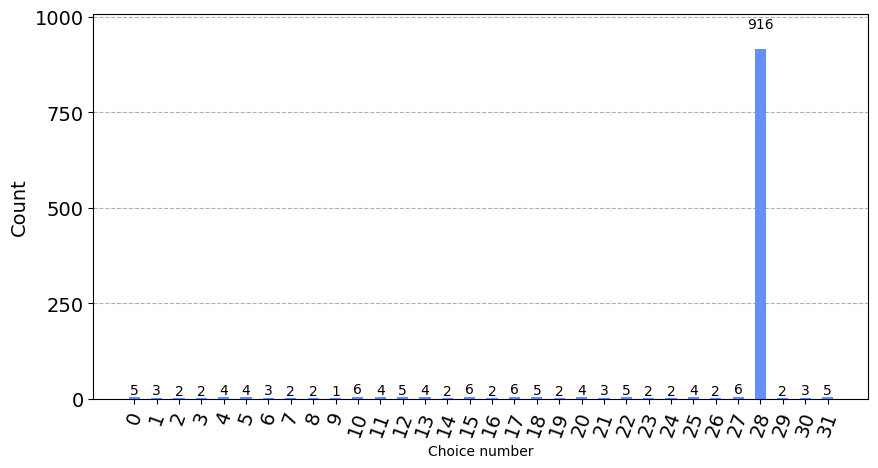

In [ ]:
backend = Aer.get_backend('qasm_simulator')
grover = Grover(iterations=3, quantum_instance=backend)
result = grover.amplify(problem)

# Extracting probabilities from the result of solving Grover
counts = result.circuit_results[0]
counts = counts.int_outcomes()

# Plotting probabilities 
# Don't worry about all the details of how the plot is made
# All the code after the first line just makes the plot look nice
plot = plot_histogram(counts,figsize=(10, 5))
ax = plot.gca()
xticks = []
ax.set_xlabel("Choice number")
display(plot)

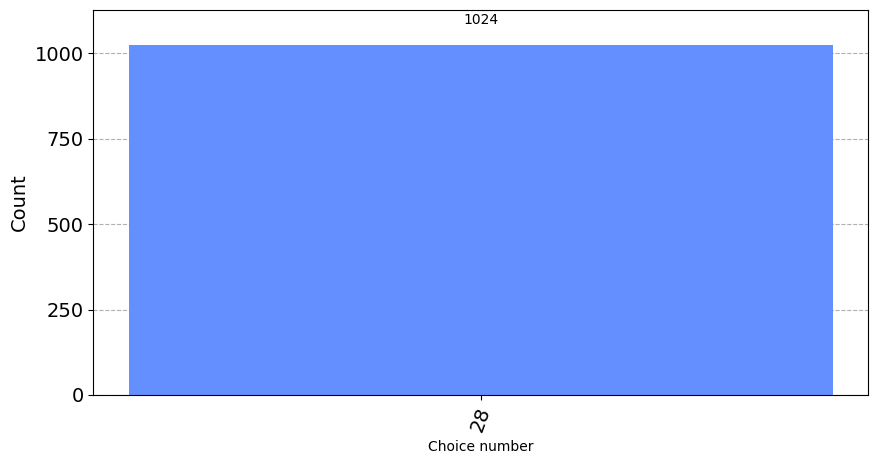

In [ ]:
backend = Aer.get_backend('qasm_simulator')
grover = Grover(iterations=4, quantum_instance=backend)
result = grover.amplify(problem)

# Extracting probabilities from the result of solving Grover
counts = result.circuit_results[0]
counts = counts.int_outcomes()

# Plotting probabilities 
# Don't worry about all the details of how the plot is made
# All the code after the first line just makes the plot look nice
plot = plot_histogram(counts,figsize=(10, 5))
ax = plot.gca()
xticks = []
ax.set_xlabel("Choice number")
display(plot)

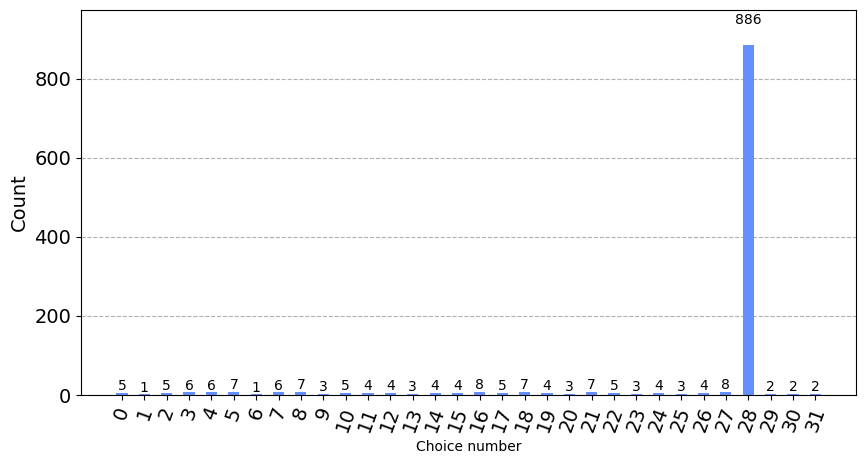

In [ ]:
backend = Aer.get_backend('qasm_simulator')
grover = Grover(iterations=5, quantum_instance=backend)
result = grover.amplify(problem)

# Extracting probabilities from the result of solving Grover
counts = result.circuit_results[0]
counts = counts.int_outcomes()

# Plotting probabilities 
# Don't worry about all the details of how the plot is made
# All the code after the first line just makes the plot look nice
plot = plot_histogram(counts,figsize=(10, 5))
ax = plot.gca()
xticks = []
ax.set_xlabel("Choice number")
display(plot)

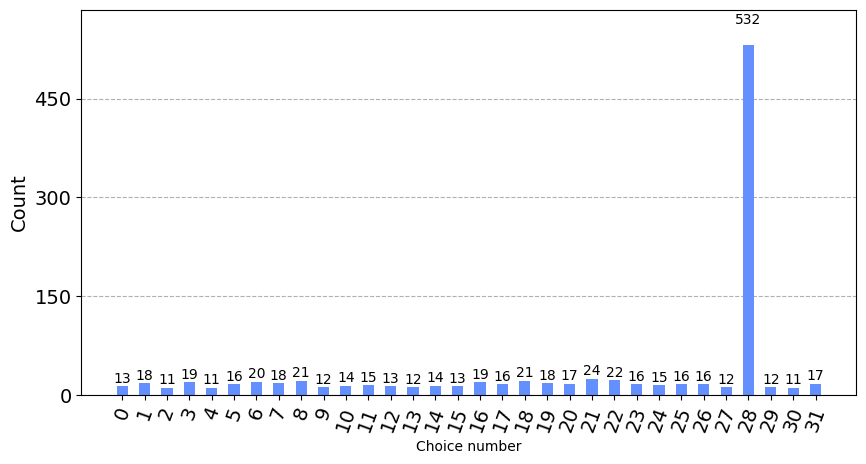

In [ ]:
backend = Aer.get_backend('qasm_simulator')
grover = Grover(iterations=6, quantum_instance=backend)
result = grover.amplify(problem)

# Extracting probabilities from the result of solving Grover
counts = result.circuit_results[0]
counts = counts.int_outcomes()

# Plotting probabilities 
# Don't worry about all the details of how the plot is made
# All the code after the first line just makes the plot look nice
plot = plot_histogram(counts,figsize=(10, 5))
ax = plot.gca()
xticks = []
ax.set_xlabel("Choice number")
display(plot)

1. 5
2. 4

#### **Problem #3.4**
**Independently,** play around with the size of the problem (`number_choices`) and the number of iterations and see how the circuit scales. You will find that the circuit becomes really big even for `number_choices=16`!

#End of notebook
---
© 2023 The Coding School, All rights reserved